### 使用PyMuPDF提取文本块结构（含坐标）

In [ ]:
import fitz  # PyMuPDF

def extract_structured_pdf_pymupdf(pdf_path):
    doc = fitz.open(pdf_path)
    for page_num, page in enumerate(doc):
        # 提取文本块（坐标、文本、字体信息等）
        blocks = page.get_text("blocks")
        print(f"Page {page_num + 1} Blocks:")
        for block in blocks:
            x0, y0, x1, y1, text, block_no, block_type = block
            print(f"Block {block_no} (Type {block_type}): [{x0}, {y0}, {x1}, {y1}]\n{text}\n")

# 示例调用
extract_structured_pdf_pymupdf("structured.pdf")

### 使用pdfplumber提取文本和表格（两种方法二选一）

In [7]:
import pdfplumber
import json
import os
import re

def extract_all_pdfs_in_directory(directory_path, output_json="output.json"):
    """
    遍历指定目录下的所有PDF文件(按文件名升序排列)，提取所有文本内容，并将结果统一保存至一个dict中
    键格式为'pdf名_页码'
    
    Args:
        directory_path: PDF文件所在的目录路径
        output_json: 输出JSON文件的路径
        
    Returns:
        包含所有PDF文本内容的字典
    """
    # 存储所有PDF的文本内容
    all_results = {}
    
    # 获取目录下所有PDF文件并按名称排序
    pdf_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.pdf')]
    pdf_files.sort()  # 按文件名升序排序
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        # 获取不带扩展名的PDF文件名
        pdf_name = os.path.splitext(pdf_file)[0]
        
        # 打开PDF并提取文本
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages, start=1):
                # 提取文本并合并换行
                text = page.extract_text()
                
                # 处理空页和换行符
                if text:
                    # 替换换行符为空格，并去除首尾空白
                    clean_text = text.replace('\n', ' ').strip()
                else:
                    clean_text = ""
                
                # 使用"pdf名_页码"格式作为键
                key = f"{pdf_name}_{page_num}"
                all_results[key] = clean_text
    
    # 保存为JSON文件
    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)
    
    return all_results

def extract_structured_pdf_pdfplumber(pdf_path, output_json="output.json"):
    """
    提取单个PDF文件的文本内容
    
    Args:
        pdf_path: PDF文件的路径
        output_json: 输出JSON文件的路径
        
    Returns:
        包含PDF文本内容的字典，键为页码
    """
    result = {}
    
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            # 提取文本并合并换行
            text = page.extract_text()
            
            # 处理空页和换行符
            if text:
                # 替换换行符为空格，并去除首尾空白
                clean_text = text.replace('\n', ' ').strip()
            else:
                clean_text = ""
            
            result[page_num] = clean_text
    
    # 保存为JSON文件
    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(result, f, ensure_ascii=False, indent=2)
    
    return result

# 使用示例
if __name__ == "__main__":
    # 提取指定目录下的所有PDF
    all_pdf_data = extract_all_pdfs_in_directory("D:/Datasets/教材/政治教材pdf")
    
    # 提取单个PDF
    # extract_structured_pdf_pdfplumber("D:/Datasets/教材/政治教材pdf/初中/义务教育教科书 道德与法治 八年级 上册_1725097531784.pdf",
    #                                   "D:/Datasets/教材/政治教材pdf/初中/义务教育教科书 道德与法治 八年级 上册_1725097531784.json"
    #                                  )

### 格式控制（后续手动修正了两条文本提取有问题的数据）

In [9]:
import json
import re

def process_json_file(file_path):
    # 从文件中读取JSON数据
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # 处理JSON数据
    result = {}
    
    # 遍历字典中的键值对
    for key, value in data.items():
        if isinstance(value, str):
            # 删除所有英文字母、空格和◆符号
            processed_value = re.sub(r'[a-zA-Z\s◆]', '', value)
            # 删除开头和结尾的阿拉伯数字
            processed_value = re.sub(r'^[0-9]+', '', processed_value)
            processed_value = re.sub(r'[0-9]+$', '', processed_value)
            result[key] = processed_value
        elif isinstance(value, dict):
            # 递归处理嵌套字典
            result[key] = process_json(value)
        elif isinstance(value, list):
            # 处理列表中的每个元素
            result[key] = [process_json(item) if isinstance(item, dict) 
                          else process_string(item) if isinstance(item, str)
                          else item for item in value]
        else:
            # 对于非字符串值，保持原样
            result[key] = value
    
    return result

def process_string(text):
    """处理字符串：删除英文字母、空格、◆符号，以及首尾的阿拉伯数字"""
    if not isinstance(text, str):
        return text
    # 删除所有英文字母、空格和◆符号
    result = re.sub(r'[a-zA-Z\s◆]', '', text)
    # 删除开头和结尾的阿拉伯数字
    result = re.sub(r'^[0-9]+', '', result)
    result = re.sub(r'[0-9]+$', '', result)
    return result

def process_json(data):
    """递归处理字典或列表中的所有字符串值"""
    if isinstance(data, dict):
        result = {}
        for key, value in data.items():
            if isinstance(value, str):
                result[key] = process_string(value)
            else:
                result[key] = process_json(value)
        return result
    elif isinstance(data, list):
        return [process_json(item) for item in data]
    else:
        return data

# 使用示例
if __name__ == "__main__":
    # 替换为实际JSON文件路径
    file_path = "output.json"
    
    processed_data = process_json_file(file_path)
    
    # 打印处理后的结果
    print(json.dumps(processed_data, ensure_ascii=False, indent=4))
    
    # 如果需要保存结果到新文件
    with open("processed_data.json", 'w', encoding='utf-8') as outfile:
        json.dump(processed_data, outfile, ensure_ascii=False, indent=4)


{
    "010_1": "第一单元我是小学生啦好好学习，天天向上。",
    "010_2": "开开心心上学去第1课上学啦，真高兴学校是你学本领、学校什么长见识的地方……样呢？今天你就是小学生啦，祝贺你！1快走，上学啦！",
    "010_3": "第一单元我是小学生啦王晓，你好！老师好！",
    "010_4": "爱新书，爱书包书里有很多知识，要爱护它们哟！这本书谢谢老师！真有意思！这么新的书，我们给它们包上书皮吧！怎样把新书保护好呢？",
    "010_5": "第一单元我是小学生啦我的书包是奶奶送给我的，这是爸爸她还绣上了我的名字……送我的新书包。我会把它们装整齐。我还带来了……小书包，别着急，用品文具想仔细。大大小小排个队，样样不少都爱惜。我们都是好伙伴，天天一起上学去。",
    "010_6": "我向国旗敬个礼第2课升国旗了美丽的旗，庄严的旗。四颗小星，朝向一颗大星。不管在哪里，看到五星红旗，升国旗都要停下来。我们的国旗，升国旗时要肃立、脱帽。我们深深爱着您。",
    "010_7": "第一单元我是小学生啦升国旗时，要面向国旗，行注目礼。少先队员行队礼。",
    "010_8": "学唱国歌国歌响起时，有的运动员会激动得流下眼泪。唱国歌时，我会站起来跟着一起大声唱。唱国歌时，我心里很……",
    "010_9": "第一单元我是小学生啦唱国歌时要严肃……我知道跟国歌有关的故事……",
    "010_10": "这是我们的校园第3课校园探秘我发现校园里还有……运动场",
    "010_11": "第一单元我是小学生啦阅览室科学教室兴趣活动室音乐教室劳动实践基地",
    "010_12": "我喜欢的地方我喜欢的地方是……，因为……要注意安全哟！我喜欢的地方是花坛，这里很漂亮，我还在这儿交到了朋友。",
    "010_13": "第一单元我是小学生啦这个地方很特别这个地方很不一样，是做什么用的呢？学校做午餐的老师不上课地方在哪里呢？时会在哪儿？",
    "010_14": "平平安安回家来第4课回家路不一样我和妈妈走路回家……我和同伴一起回家。回家的路不一样，我回家，路上经过。",
    "010_15": "第一单元我是小学生啦交通安全记心上放学回家路上，要注意交通安全。怎样做才安全呢？嘀！嘀

### 滑窗法生成文段，组成Qwen-plus调用prompt

In [11]:
import json


def gen_qwen_api_prompt(input_file, window_size: int = 30, stride: int = 10):
    """
    python，将以下格式的json转为[{"system": <system_prompt>, "prompt": <user_prompt>}, ...]的格式：
        {
            "010_1": "第一单元我是小学生啦好好学习，天天向上。",
            "010_2": "开开心心上学去第1课上学啦，真高兴学校是你学本领、学校什么长见识的地方……样呢？今天你就是小学生啦，祝贺你！1快走，上学啦！",
            "010_3": "第一单元我是小学生啦王晓，你好！老师好！",
            ...
        }
    """
    # 读取输入JSON文件
    with open(input_file, 'r', encoding='utf-8') as f:
        data_in = json.load(f)
    # 转为list格式，便于滑窗处理
    data = []
    for idx, user_prompt in data_in.items():
        data.append(user_prompt)

    # 声明转换后的数据列表
    converted_data = []

    # 系统提示
    system_prompt = "请从下面的内容中提取最重要的核心实体知识点，并提供不超过200字的摘要\n教材来源：中小学生政治课教材\n"

    for idx in range(0, len(data)-window_size+1, stride):
        # 提取窗口内的数据
        window_data = data[idx:idx+window_size]
        # 将窗口内的数据拼接成一个字符串
        user_prompt = "".join(window_data)
        # 创建新格式
        converted_item = {
            "idx": idx,
            "system": system_prompt,
            "prompt": user_prompt
        }

        converted_data.append(converted_item)

    return converted_data


"""指定相应的特征窗口大小"""
# # test
# window_size = 30
# stride = 10

# 单元
window_size = 10
stride = 5

# # 课
# window_size = 6
# stride = 3

# # point
# window_size = 3
# stride = 2

# 输入输出文件名
root_dir = 'data/abstract'
file_input = f'processed_data.json'
response_json = f'{root_dir}/response_abs_w{window_size}_s{stride}.json'

# 初始化输出文件
with open(response_json, 'w', encoding='utf-8') as file:
    json.dump([], file, ensure_ascii=False, indent=4)

"""QwenPlusClient"""
prompts = gen_qwen_api_prompt(file_input, window_size, stride)
    

#### 调用my_qplus_backup中的任务1

In [13]:
print(len(prompts))
print(prompts[0])

176
{'idx': 0, 'system': '请从下面的内容中提取最重要的核心实体知识点，并提供不超过200字的摘要\n教材来源：中小学生政治课教材\n', 'prompt': '第一单元我是小学生啦好好学习，天天向上。开开心心上学去第1课上学啦，真高兴学校是你学本领、学校什么长见识的地方……样呢？今天你就是小学生啦，祝贺你！1快走，上学啦！第一单元我是小学生啦王晓，你好！老师好！爱新书，爱书包书里有很多知识，要爱护它们哟！这本书谢谢老师！真有意思！这么新的书，我们给它们包上书皮吧！怎样把新书保护好呢？第一单元我是小学生啦我的书包是奶奶送给我的，这是爸爸她还绣上了我的名字……送我的新书包。我会把它们装整齐。我还带来了……小书包，别着急，用品文具想仔细。大大小小排个队，样样不少都爱惜。我们都是好伙伴，天天一起上学去。我向国旗敬个礼第2课升国旗了美丽的旗，庄严的旗。四颗小星，朝向一颗大星。不管在哪里，看到五星红旗，升国旗都要停下来。我们的国旗，升国旗时要肃立、脱帽。我们深深爱着您。第一单元我是小学生啦升国旗时，要面向国旗，行注目礼。少先队员行队礼。学唱国歌国歌响起时，有的运动员会激动得流下眼泪。唱国歌时，我会站起来跟着一起大声唱。唱国歌时，我心里很……第一单元我是小学生啦唱国歌时要严肃……我知道跟国歌有关的故事……这是我们的校园第3课校园探秘我发现校园里还有……运动场第一单元我是小学生啦阅览室科学教室兴趣活动室音乐教室劳动实践基地我喜欢的地方我喜欢的地方是……，因为……要注意安全哟！我喜欢的地方是花坛，这里很漂亮，我还在这儿交到了朋友。第一单元我是小学生啦这个地方很特别这个地方很不一样，是做什么用的呢？学校做午餐的老师不上课地方在哪里呢？时会在哪儿？平平安安回家来第4课回家路不一样我和妈妈走路回家……我和同伴一起回家。回家的路不一样，我回家，路上经过。第一单元我是小学生啦交通安全记心上放学回家路上，要注意交通安全。怎样做才安全呢？嘀！嘀！我路上要经过一个铁路道口。红灯停，绿灯行，遇到黄灯等一等。靠右行，不追跑，过路口时左右瞧。我还知道……路上的温暖爸爸！谢谢叔叔！奶奶，您也别淋着。路上有温暖，我也感受到了……哥哥姐姐陪我一起回家。第二单元过好校园生活我们在多彩的生活中茁壮成长。老师，您好！第5课我的老师们猜猜是哪位老师短头发、笑眯眯……我很喜欢老师，因为……第二单

### 处理Qwen返回，提取摘要部分，并使用BGE嵌入

In [1]:
"""提取摘要部分"""
import json
import ast


def trim_string(input_string):
    """剔除掉API调用模型返回结果中的前后缀"""
    if input_string.startswith("```json\n"):
        input_string = input_string[len("```json\n"):]
    if input_string.endswith("\n```"):
        input_string = input_string[:-len("\n```")]
    return input_string


# 读取文件
file_path = f'response_w{window_size}_s{stride}.json'
with open(file_path, 'r', encoding='utf-8') as file:
    abs_list = json.load(file)

abstract_list = []
for abs in abs_list:
    temp = trim_string(abs['output'])
    try:
        temp = ast.literal_eval(temp)
    except:
        print(temp)
        raise ValueError('temp is not a dict')
    
    temp = temp['摘要']
    abstract_list.append(temp)

print(len(abstract_list))


80


In [2]:
"""BGE嵌入"""
# 导入必要的库
from transformers import AutoTokenizer, AutoModel
import torch
import json
import numpy as np


# 将待嵌入整理为list（顺序排列）
contents = abstract_list

# 输出文件名
file_emb = r'/mnt/new_pfs/liming_team/auroraX/songchentao/MyCDM/data/250318_abs_embeds_bge.npy'
file_token = r'/mnt/new_pfs/liming_team/auroraX/songchentao/MyCDM/data/250318_abs_tokens_bge.json'

# 加载BGE模型和分词器
# model_name = "BAAI/bge-small-zh-v1.5"  # 小型中文模型
# model_name = "BAAI/bge-base-zh-v1.5"   # 基础中文模型
model_name = "/mnt/new_pfs/liming_team/auroraX/songchentao/llama/bge-large-zh-v1.5"  # 大型中文模型
# model_name = "/mnt/new_pfs/liming_team/auroraX/LLM/bge-large-en-v1.5"              # 大型英文模型

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # 设置为评估模式

# 生成嵌入
embeddings = []
inputs_all = []
batch_size = len(contents)  # 根据GPU内存调整批量大小

start_idx = 0  # 计算总批次数以便显示进度
total_batches = (len(contents) - start_idx + batch_size - 1) // batch_size

with torch.no_grad():
    for i in range(0, len(contents), batch_size):
        # 显示进度
        current_batch = (i - start_idx) // batch_size + 1
        if current_batch % 100 == 0:
            print(f'处理批次 {current_batch}/{total_batches} ({(current_batch/total_batches*100):.1f}%)')
        batch_texts = contents[i:i+batch_size]
        # 使用transformers的tokenizer和model
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs_all.append(inputs)
        # 嵌入（如需）
        outputs = model(**inputs)
        # 使用[CLS]标记的输出作为文本嵌入
        batch_embeddings = outputs.last_hidden_state[:, 0]  # 等效于[:, 0, :]
        # 标准化嵌入向量
        batch_embeddings = torch.nn.functional.normalize(batch_embeddings, p=2, dim=1)
        embeddings.append(batch_embeddings)

# 合并所有批次的嵌入
if batch_size == len(contents):
    inputs_all = inputs_all[0]
    embeddings = embeddings[0]
else:
    raise ValueError

# 保存分词结果
output = {}
for key, value in inputs_all.items():  # attention_mask、input_ids、token_type_ids
    output[key] = value.numpy().tolist()
# print(output)
with open(file_token, 'w', encoding='utf-8') as file:
    json.dump(output, file, ensure_ascii=False)  # , indent=4

# 保存嵌入结果
embeddings = embeddings.numpy()
np.save(file_emb, embeddings)

print(embeddings.shape)
print(type(embeddings))

(80, 1024)
<class 'numpy.ndarray'>


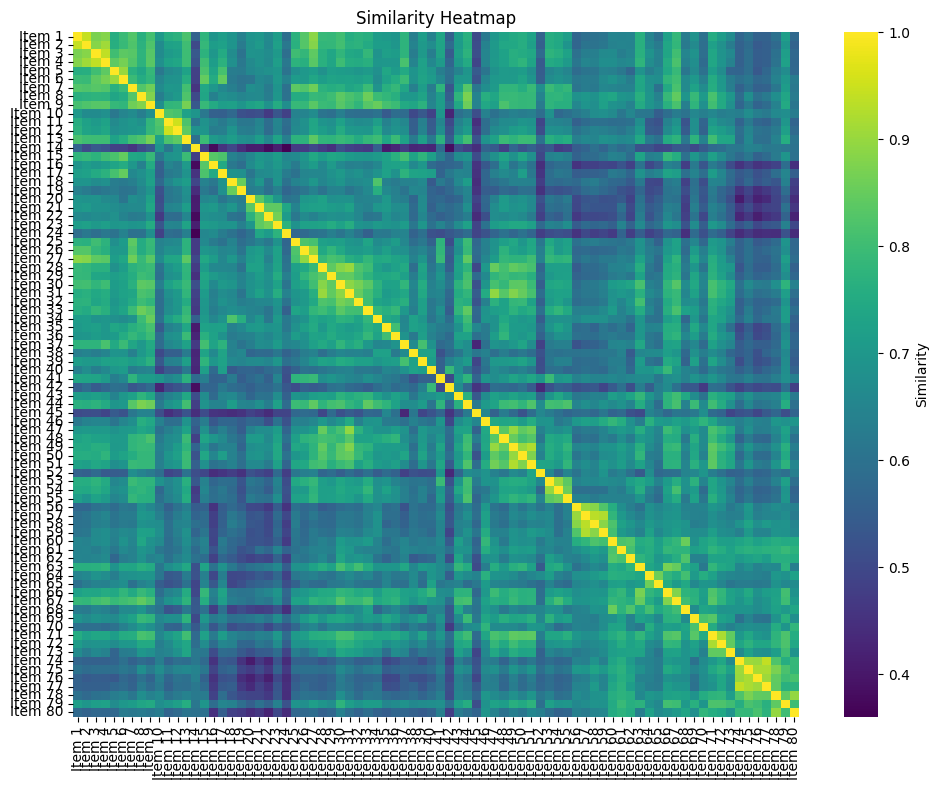

In [8]:
"""计算余弦相似度&画图"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_similarity(_embeddings):
    """
    计算文本嵌入之间的余弦相似度
    """
    _similarity_matrix = np.zeros((len(_embeddings), len(_embeddings)))
    for i in range(len(_embeddings)):
        for j in range(len(_embeddings)):
            # 计算余弦相似度
            similarity = np.dot(_embeddings[i], _embeddings[j])
            _similarity_matrix[i][j] = similarity
    return _similarity_matrix


def plot_similarity_heatmap(similarity_matrix, labels=None, cmap='viridis', 
                           figsize=(10, 8), title='Similarity Heatmap', 
                           vmin=None, vmax=None, annot=False, fmt=''):  #  '.2f'
    """
    绘制相似度矩阵的热图
    
    参数:
    - similarity_matrix: 二维numpy数组或类似的数据结构，包含相似度值
    - labels: 可选，用于x和y轴的标签
    - cmap: 颜色映射方案，默认为'viridis'
    - figsize: 图形尺寸，默认为(10, 8)
    - title: 图形标题，默认为'Similarity Heatmap'
    - vmin, vmax: 颜色映射的最小值和最大值，默认为None(自动判断)
    - annot: 是否在每个单元格中显示数值，默认为True
    - fmt: 单元格中数值的格式，默认为'.2f'(两位小数)
    
    返回:
    - fig, ax: 图形和坐标轴对象，可用于进一步自定义
    """
    
    # 创建图形和坐标轴
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制热图
    sns.heatmap(similarity_matrix, 
                annot=annot, 
                fmt=fmt,
                cmap=cmap,
                vmin=vmin, 
                vmax=vmax,
                xticklabels=labels,
                yticklabels=labels,
                cbar_kws={'label': 'Similarity'},
                ax=ax)
    
    # 设置标题和标签
    ax.set_title(title)
    
    # 调整布局
    plt.tight_layout()
    
    return fig, ax


"""实际调用"""
# 创建一个示例相似度矩阵
# n = 5
# np.random.seed(42)
# sim_matrix = np.random.rand(n, n)

# 计算余弦相似度
sim_matrix = calculate_similarity(embeddings)

# 确保对角线为1(自己与自己的相似度为1)
np.fill_diagonal(sim_matrix, 1)
# 确保矩阵对称(相似度矩阵通常是对称的)
sim_matrix = (sim_matrix + sim_matrix.T) / 2

# # 示例标签
labels = [f'Item {i+1}' for i in range(embeddings.shape[0])]
# labels = ['' for i in range(embeddings.shape[0])]

# 绘制热图
fig, ax = plot_similarity_heatmap(sim_matrix, labels=labels)
plt.show()






### 取偏对角线，并滑动平均后绘制折线图

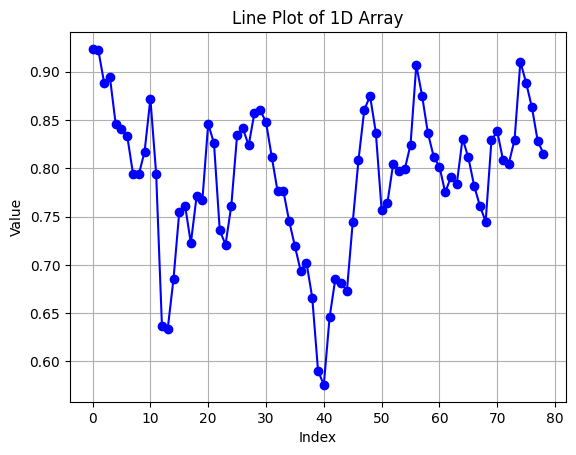

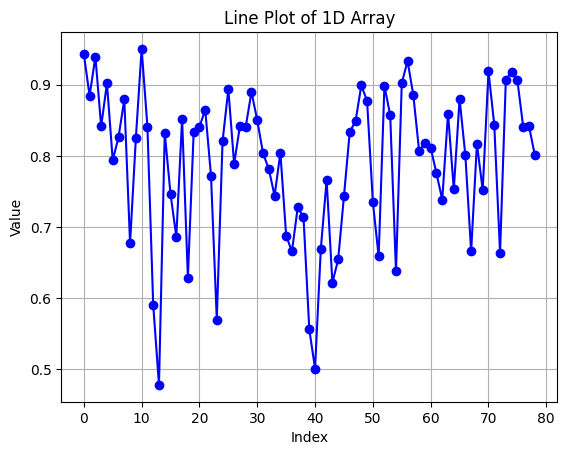

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def smooth(data, window_size):
    """
    对一维NumPy数组进行平滑（滑动平均）
    
    参数:
    - data: 一维NumPy数组
    - window_size: 平滑窗口大小
    
    返回:
    - 平滑后的NumPy数组
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    
    # 确保窗口大小是奇数
    if window_size % 2 == 0:
        window_size += 1
    
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    
    smoothed_data = np.convolve(extended_data, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed_data


def plot_1d_array(data, title='Line Plot of 1D Array', xlabel='Index', ylabel='Value', color='blue', linestyle='-', marker='o'):
    """
    绘制一维NumPy数组的折线图

    参数:
    - data: 一维NumPy数组
    - title: 图形标题
    - xlabel: X轴标签
    - ylabel: Y轴标签
    - color: 线条颜色
    - linestyle: 线型
    - marker: 数据点标记
    
    返回:
    - None
    """
    # 创建一个新的图形
    plt.figure()
    # 绘制折线图
    plt.plot(data, color=color, linestyle=linestyle, marker=marker)
    # 添加标题和标签
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # 显示网格
    plt.grid(True)
    # 显示图形
    plt.show()


# 实际调用
array = sim_matrix
# array = np.random.rand(80, 80)

# 取偏对角线（上方的偏对角线）
upper_diag = np.diag(array, k=1)
# print("Upper diagonal (k=1):")
# print(type(upper_diag))

# 滑动平均
smoothed_data = smooth(upper_diag, window_size=3)

# 绘制折线图
plot_1d_array(smoothed_data)
plot_1d_array(upper_diag)


### 滑窗法查找局部最大值并在图中标出

[3, 10, 16, 18, 20, 26, 29, 33, 37, 42, 48, 52, 56, 62, 64, 70, 74]
[0, 3, 10, 16, 18, 20, 26, 29, 33, 37, 42, 48, 52, 56, 62, 64, 70, 74]


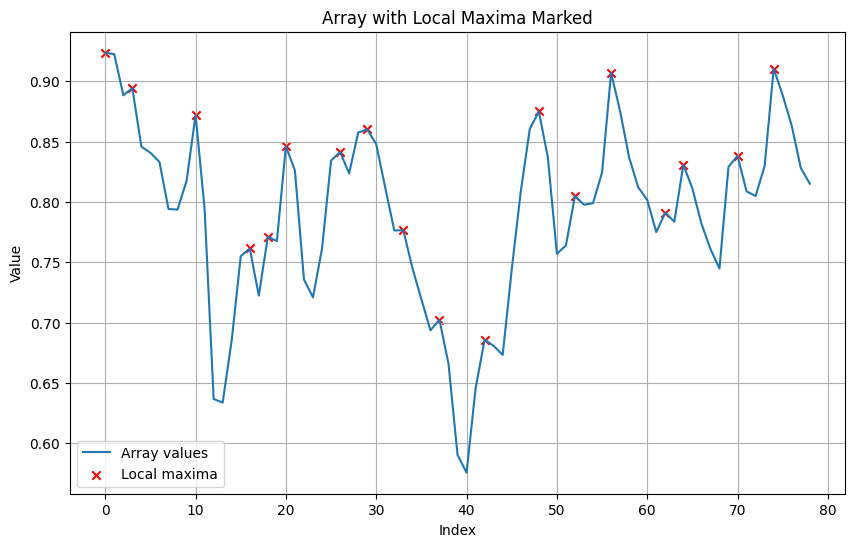

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def find_local_maxima_with_window(arr, window_size):
    n = len(arr)
    local_maxima_indices = []

    half_window = window_size // 2

    for i in range(half_window, n - half_window):
        window = arr[i - half_window:i + half_window + 1]
        if arr[i] == np.max(window):
            local_maxima_indices.append(i)
    
    return local_maxima_indices


def find_local_maxima_indices(arr, window_size):
    n = len(arr)
    local_maxima_indices = []

    half_window = window_size // 2
    
    # 数组最小值
    min_val = np.min(arr)
    
    # 左右填充，填充长度为half_window
    padded_arr = np.pad(arr, half_window, mode='constant', constant_values=min_val)
    
    for i in range(half_window, n + half_window):  # 注意范围是填充后的数组长度
        window = padded_arr[i - half_window:i + half_window + 1]
        if padded_arr[i] == np.max(window):
            actual_index = i - half_window  # 转换为原数组中的索引
            if 0 <= actual_index < n:
                local_maxima_indices.append(actual_index)
    
    return local_maxima_indices


def plot_array_with_maxima(arr, maxima_indices):
    plt.figure(figsize=(10, 6))
    plt.plot(arr, label='Array values')
    plt.scatter(maxima_indices, arr[maxima_indices], color='red', marker='x', label='Local maxima')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Array with Local Maxima Marked')
    plt.grid(True)
    plt.show()


# 定义窗口大小
window_size = 3

# 查找局部极大值的索引
maxima_indices = find_local_maxima_with_window(smoothed_data, window_size)
print(maxima_indices)
# 修正：添加边界padding
maxima_indices = find_local_maxima_indices(smoothed_data, window_size)
print(maxima_indices)

# 绘制数组并标注局部极大值
plot_array_with_maxima(smoothed_data, maxima_indices)

### 提取对应的知识点标注集合，再调用大模型进行总结

In [16]:
"""提取摘要部分"""
import json
import ast


def trim_string(input_string):
    """切除调用模型API返回结果中的前后缀"""
    if input_string.startswith("```json\n"):
        input_string = input_string[len("```json\n"):]
    if input_string.endswith("\n```"):
        input_string = input_string[:-len("\n```")]
    return input_string


file_path = 'response_30.json'

with open(file_path, 'r', encoding='utf-8') as file:
    kc_list = json.load(file)

item_list = []
for kc in kc_list:
    temp = trim_string(kc['output'])
    try:
        temp = ast.literal_eval(temp)
    except:
        print(temp)
        raise ValueError('temp is not a dict')
    
    temp = temp['最核心实体知识点']
    item_list.append(temp)

print(len(item_list))
print(item_list)


80
['小学生校园生活', '小学生校园生活与习惯养成', '校园生活与良好习惯', '养成良好习惯', '礼貌与文明行为', '文明行为与良好习惯', '目标设定与实现、克服马虎、改错成长、精神面貌、友好相处、求助与帮助、分享的魔力、合作的重要性', '知错能改、团队合作、家人关爱', '友好相处、求助与帮助、分享合作、家庭关爱、整理习惯、做家务、儿童节', '少先队与红领巾的意义', '少先队与儿童节', '少先队与儿童节', '新时代好少年的品质与班级生活规则', '国庆节与国家象征', '班级规则与公共文明', '班级设计与公物爱护', '公共场所的行为规范与社会责任', '家乡的美与文化传承', '家乡人的优秀品质与家乡变化', '快乐与健康游戏', '环保与资源节约', '环保与可持续发展', '环保与个人成长', '环保搭档与绿色生活', '学习方法与坚持的重要性', '学习与成长的关系及学习方法', '快乐学习与校园生活', '生命教育与安全成长', '教师的职业价值与学生安全成长', '义务教育法与儿童受教育权、生命安全与自我保护、家庭关爱与沟通', '安全与生命教育', '安全意识与自我保护', '家庭与亲情、自我认知与成长、诚实品质', '家的文化意义与个人特点', '接纳不同、诚实守信、同伴相处、社区归属感', '诚实守信与团队合作', '公共设施的重要性及爱护公共设施', '邻里关系与公共生活', '公共设施、规则与爱心', '公共生活中的规则与交通通信发展', '少年有梦，规划初中生活', '交通和通信的发展及其影响', '公民的通信自由和通信秘密受法律保护', '认识自己、接纳自己、实现梦想、家庭意义与建设、师生关系', '友谊的真谛与建立和谐人际关系的方法', '建设美好家庭与珍爱生命', '珍爱生命、敬畏生命、守护生命', '集体生活与个人成长、珍爱生命与守护生命', '珍爱生命与确立人生目标', '珍爱生命与追求美好人生', '珍爱生命、树立正确人生目标、端正人生态度、实现人生价值', '积极的人生态度', '青春期身心发展与情绪情感管理', '青春期异性交往、情绪管理与自尊自信', '情绪与情感管理、自尊自信自强的培养', '中华优秀传统文化的核心思想理念', '中华优秀传统文化的核心思想理念与人文精神', '中华优秀传统文化

In [17]:
import json

# # 临时（正常情况下使用上文代码块运行得到的maxima_indices）
# maxima_indices = [0, 3, 10, 16, 18, 20, 26, 29, 33, 37, 42, 48, 52, 56, 62, 64, 70, 74]

"""使用Qwen的话不用，在封装API输入时单独传入system prompt"""
# prompt = """给定一组以分号为间隔的文章主题，请提炼出最主要的单一实体知识点。问题示例：校园生活与良好习惯; 养成良好习惯; 礼貌与文明行为

# 步骤：
# 1. 分析所给定的主题，分开处理每个分号间隔部分的内容。
# 2. 从每个主题中提取出最核心的关键词或短语。
# 3. 找到这些关键词或短语的共性，确定一个最主要的知识点。

# 输入：{}
# 输出:
# """

radius = 1
result = []
for idx in maxima_indices:
    temp = item_list[max(0, idx-1): min(len(item_list), idx+2)]
    temp = '; '.join(temp)
    # temp = prompt.format(temp)  # 同上，省略该步骤
    result.append(temp)

print(len(result))
print(json.dumps(result, ensure_ascii=False, indent=4))

with open("prompts.json", 'w', encoding='utf-8') as outfile:
    json.dump(result, outfile, ensure_ascii=False, indent=4)



18
[
    "小学生校园生活; 小学生校园生活与习惯养成",
    "校园生活与良好习惯; 养成良好习惯; 礼貌与文明行为",
    "少先队与红领巾的意义; 少先队与儿童节; 少先队与儿童节",
    "班级设计与公物爱护; 公共场所的行为规范与社会责任; 家乡的美与文化传承",
    "家乡的美与文化传承; 家乡人的优秀品质与家乡变化; 快乐与健康游戏",
    "快乐与健康游戏; 环保与资源节约; 环保与可持续发展",
    "学习与成长的关系及学习方法; 快乐学习与校园生活; 生命教育与安全成长",
    "教师的职业价值与学生安全成长; 义务教育法与儿童受教育权、生命安全与自我保护、家庭关爱与沟通; 安全与生命教育",
    "家庭与亲情、自我认知与成长、诚实品质; 家的文化意义与个人特点; 接纳不同、诚实守信、同伴相处、社区归属感",
    "公共设施的重要性及爱护公共设施; 邻里关系与公共生活; 公共设施、规则与爱心",
    "交通和通信的发展及其影响; 公民的通信自由和通信秘密受法律保护; 认识自己、接纳自己、实现梦想、家庭意义与建设、师生关系",
    "集体生活与个人成长、珍爱生命与守护生命; 珍爱生命与确立人生目标; 珍爱生命与追求美好人生",
    "积极的人生态度; 青春期身心发展与情绪情感管理; 青春期异性交往、情绪管理与自尊自信",
    "中华优秀传统文化的核心思想理念; 中华优秀传统文化的核心思想理念与人文精神; 中华优秀传统文化的核心思想理念与人文精神",
    "法律保护公民权益; 犯罪与刑罚、正当防卫、不良行为与违法犯罪、网络生活规范、社会秩序与规则; 社会生活与规则",
    "社会生活与规则; 网络生活与社会规则; 社会规则与法治",
    "责任与角色同在; 勇担社会责任与维护国家利益; 国家利益与个人利益的关系、维护国家安全的重要性",
    "宪法的地位与作用; 宪法的核心价值追求与基本原则; 宪法的核心价值和国家机构的设置与运行"
]
